# Bayesian estimation of the bivariate beta parameter

In [1]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.CRITICAL)

import os
import tqdm
import numpy as np
from scipy import stats
import pandas as pd

from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path
import abcpy

import matplotlib.pyplot as plt
import matplotlib
import arviz as az
plt.style.use('science')

import sys
sys.path.append('../scripts/python')
    
from parameter_estimation import BivariateBeta

## Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [160]:
stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v1.stan')
model1 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS':True}, 
                      stanc_options={'O1': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v2.stan')
model2 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True}, 
                      stanc_options={'Oexperimental': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v3.stan')
model3 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True}, 
                      stanc_options={'O1': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'simple_model.stan')
simple_model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True}, 
                      stanc_options={'O1': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v10.stan')
model10 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiling stan file /home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v10.stan to exe file /home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v10
INFO:cmdstanpy:compiled model executable: /home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v10


## Default hyperparameters

Generating the data

In [5]:
def generate_data(true_alpha, n, seed):
    ro = np.random.RandomState(seed=seed)
    U = ro.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    XY = np.column_stack([X,Y])
    return U[:,0], XY

## Prior predictive checking

Here we perform prior checks in the space of the moments. 
Consider $\alpha \sim \operatorname{Gamma}(a,a)$

In [43]:
def moments_sampler(a, seed, prior=1):
    rng = np.random.RandomState(seed=seed)
    moments_samples = np.zeros((10000, 5))
    for i in range(moments_samples.shape[0]):
        if prior == 1:
            alpha = rng.gamma(shape=a, scale=1/a, size=4)
        elif prior == 2:
            alpha = rng.gamma(shape=2, scale=1/a, size=4)
        elif prior == 3:
            alpha = rng.gamma(shape=a, scale=1, size=4)
        elif prior == 4:
            alpha = rng.gamma(shape=a, scale=1)
        elif prior == 5:
            p, C, lamdb = a[0], a[1], a[2]
            S = rng.binomial(n=1, p=p, size=4) == 1
            alpha = np.zeros(4)
            alpha[S] = rng.uniform(0,C, size=S.sum())
            alpha[~S] = rng.exponential(lambd, size=4-S.sum()) + C
        distribution = BivariateBeta(alpha)
        moments_samples[i] = distribution.moments()
    return moments_samples

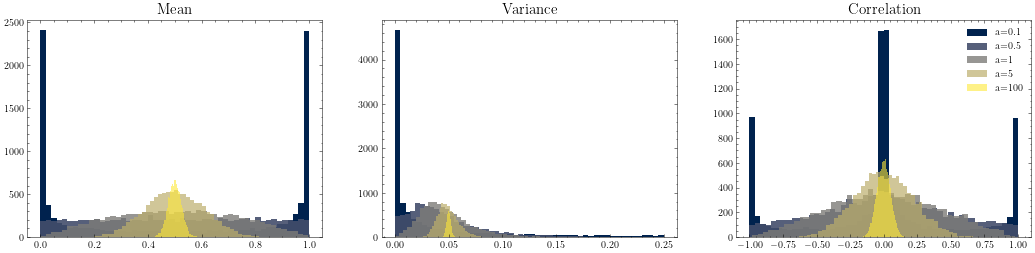

In [6]:
seed = 8393213
a_values = [0.1, 0.5, 1, 5, 100]

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(a_values))
for j, a in enumerate(a_values):
    for i in range(3):
        samples = moments_sampler(a, seed)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='a={}'.format(a), alpha=1-j*0.1)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

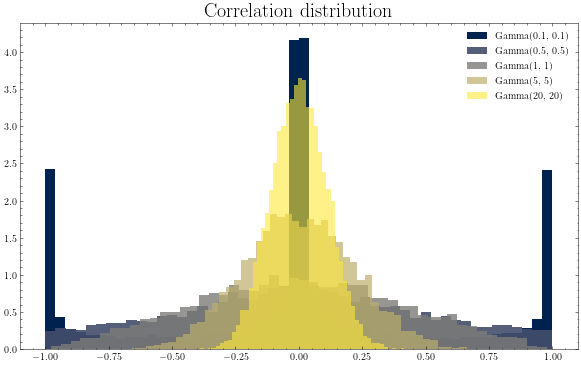

In [7]:
seed = 8393213
a_values = [0.1, 0.5, 1, 5, 20]

fig, ax = plt.subplots(figsize=(10,6))
colors = matplotlib.cm.get_cmap('cividis', len(a_values))
for j, a in enumerate(a_values):
    samples = moments_sampler(a, seed)
    ax.hist(samples[:,-1], bins=50, density=True,
            color=colors(j), label='Gamma({}, {})'.format(a, a), alpha=1-j*0.1)
    ax.set_title('Correlation distribution', fontsize=20)
plt.legend()
plt.savefig('../figures/correlation-distribution-gamma-a-a.pdf', bbox_inches='tight')
plt.show()

Consider the case $\alpha_i \sim Gamma(2, b)$. 
Notice, however that if $\alpha_i \sim Gamma(2, 1)$, then $c\alpha \sim Gamma(2,1/c)$. 
Therefore, 
$$
m_1 = \frac{c\alpha_1 + c\alpha_2}{\sum_{i=1}^4 c\alpha_i} = \frac{\alpha_1 + \alpha_2}{\sum_{i=1}^4 \alpha_i}
$$
does not depend on $c$. 
The same can be told about $\rho$.

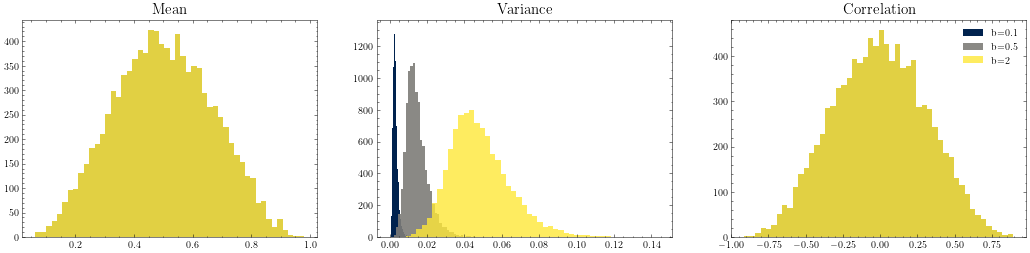

In [8]:
seed = 8393213
b_values = [0.1, 0.5, 2]

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(b_values))
for j, b in enumerate(b_values):
    for i in range(3):
        samples = moments_sampler(b, seed, prior=2)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='b={}'.format(b), alpha=1-j*0.1)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

Consider $\alpha_i \sim Gamma(a, 1)$

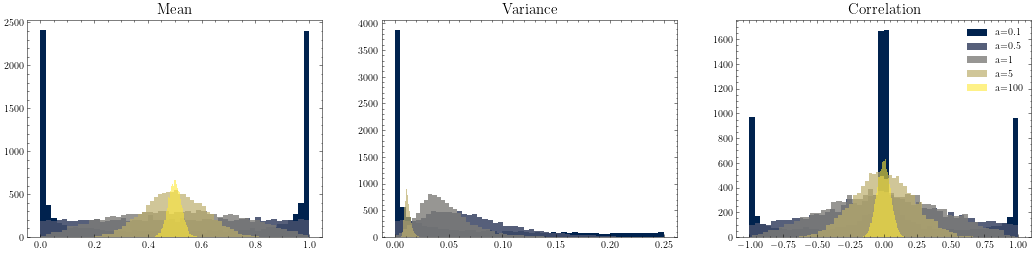

In [9]:
seed = 8393213
a_values = [0.1, 0.5, 1, 5, 100]

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(a_values))
for j, a in enumerate(a_values):
    for i in range(3):
        samples = moments_sampler(a, seed, prior=3)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='a={}'.format(a), alpha=1-j*0.1)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

Notice that when the $\alpha$ values have the same distribution, $\rho$ is centered in zero, and the mean over 1/5. 
Moreover, when $a=0.5$, we are close to the uniform case.  
In special, mean and correlation do not depend on the rate parameter, as we already verified. 

Now, we change the prior distributions for each $\alpha_i$. Consider $\alpha_i \sim Gamma(a_i, 1)$.

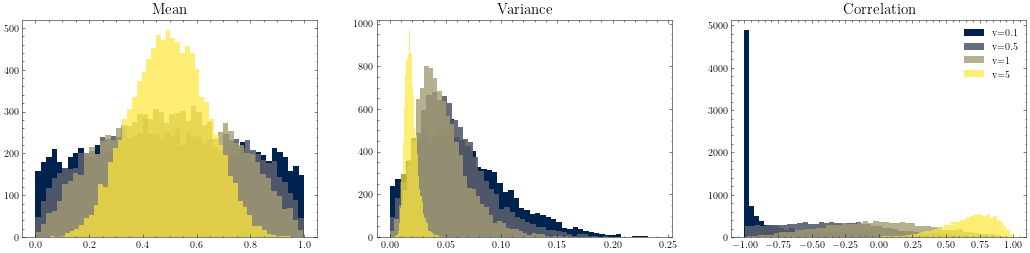

In [10]:
seed = 8393213
a_values = [0.1, 0.5, 1, 5]

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(a_values))
for j, v in enumerate(a_values):
    for i in range(3):
        a = np.array([v, 1.0, 1.0, v])
        samples = moments_sampler(a, seed, prior=4)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='v={}'.format(v), alpha=1-j*0.1)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

What happens if we use the uniform as prior?

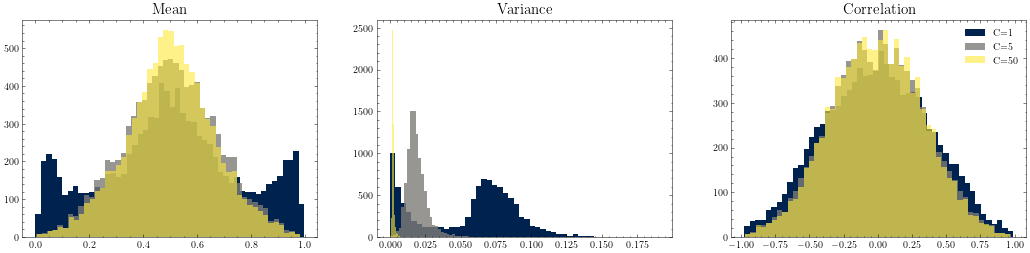

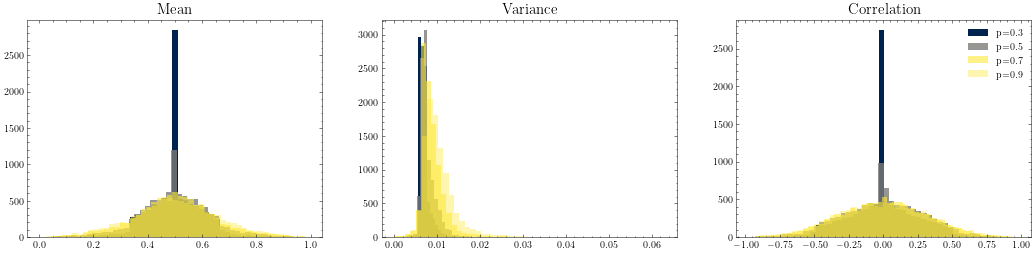

In [11]:
seed = 8393213
C_values = [1, 5, 50]
p = 0.9

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(C_values))
for j, C in enumerate(C_values):
    for i in range(3):
        # This value of lambd guarantees that the density is continuous.
        lambd = p/C/(1-p)
        a = [p, C, lambd]
        samples = moments_sampler(a, seed, prior=5)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='C={}'.format(C), alpha=1-j*0.2)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

seed = 8393213
p_values = [0.3, 0.5, 0.7, 0.9]
C = 10

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(C_values))
for j, p in enumerate(p_values):
    for i in range(3):
        # This value of lambd guarantees that the density is continuous.
        lambd = p/C/(1-p)
        a = [p, C, lambd]
        samples = moments_sampler(a, seed, prior=5)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='p={}'.format(p), alpha=1-j*0.2)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

## Posterior for different priors

In this section, we compare the posterior distributions for the different priors.

In [176]:
true_alpha = np.array([2.5, 0.1, 1.9, 1.7])
n = 50
U, XY = generate_data(true_alpha, n, seed=783210)

# Gamma hyperparameters
a = np.array([1,1,1,1])
b = np.array([1,1,1,1])

# Boojum prior
m = -0.9
r = b

# Uniform-Exponential prior
p = 0.9*np.ones(4)
lambd = np.ones(4)
c = 10*np.ones(4)

# Prior_alpha = 1 -> gamma
# Prior_alpha = 2 -> boojum
# Prior_alpha = 4 -> Uniform Exponential
# Prior_alpha = 3 or 5 -> Improper distributions

data = {'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 'n': n, 'x': XY[:,0], 'y': XY[:,1],
        'alpha': true_alpha, 'xy': XY}

In [177]:
model_fit1 = model3.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, adapt_delta=0.9)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


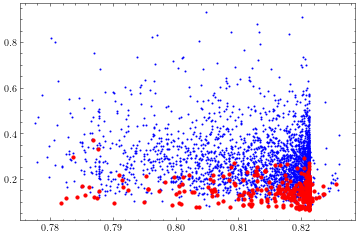

In [179]:
draws = model_fit1.draws_pd()

plt.scatter(draws[draws['divergent__'] == 0][['u[{}]'.format(i) for i in range(1,51)]].max(axis=1), 
            draws[draws['divergent__'] == 0]['alpha[2]'], 
            color='blue', s=1)
plt.scatter(draws[draws['divergent__'] == 1][['u[{}]'.format(i) for i in range(1,51)]].max(axis=1),
            draws[draws['divergent__'] == 1]['alpha[2]'], 
            color='red', s=10)

In [180]:
model_fit1.diagnose()

"Processing csv files: /tmp/tmpteyd87iw/bivariate-beta-model-v3-20220802230651_1.csv, /tmp/tmpteyd87iw/bivariate-beta-model-v3-20220802230651_2.csv, /tmp/tmpteyd87iw/bivariate-beta-model-v3-20220802230651_3.csv, /tmp/tmpteyd87iw/bivariate-beta-model-v3-20220802230651_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n545 of 4000 (13.62%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nThe E-BFMI, 0.19, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.\nIf possible, try to reparameterize the model.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisf

In [75]:
model_fit1.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-97.000,1.50000,16.000,-120.000,-98.000,-70.000,110.0,38.0,1.0
alpha[1],2.500,0.01100,0.400,1.900,2.500,3.200,1435.0,480.0,1.0
alpha[2],0.240,0.00900,0.110,0.120,0.210,0.450,140.0,47.0,1.0
alpha[3],1.900,0.01400,0.320,1.400,1.900,2.500,500.0,167.0,1.0
alpha[4],1.500,0.00740,0.250,1.100,1.500,1.900,1101.0,368.0,1.0
...,...,...,...,...,...,...,...,...,...
u4[46],0.073,0.00044,0.018,0.029,0.083,0.085,1726.0,577.0,1.0
u4[47],0.068,0.00066,0.032,0.014,0.069,0.120,2359.0,788.0,1.0
u4[48],0.730,0.00058,0.023,0.670,0.740,0.740,1582.0,529.0,1.0


In [65]:
model_fit1.diagnose()

"Processing csv files: /tmp/tmpteyd87iw/bivariate-beta-model-v11-20220802221431_1.csv, /tmp/tmpteyd87iw/bivariate-beta-model-v11-20220802221431_2.csv, /tmp/tmpteyd87iw/bivariate-beta-model-v11-20220802221431_3.csv, /tmp/tmpteyd87iw/bivariate-beta-model-v11-20220802221431_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n526 of 4000 (13.15%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nThe E-BFMI, 0.18, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.\nIf possible, try to reparameterize the model.\n\nEffective sample size satisfactory.\n\nSplit R-hat values sa

## What else?

In [ ]:
data['prior_alpha'] = 1
model_fit1 = model2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 2
model_fit2 = model2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 4
model_fit3 = model2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)

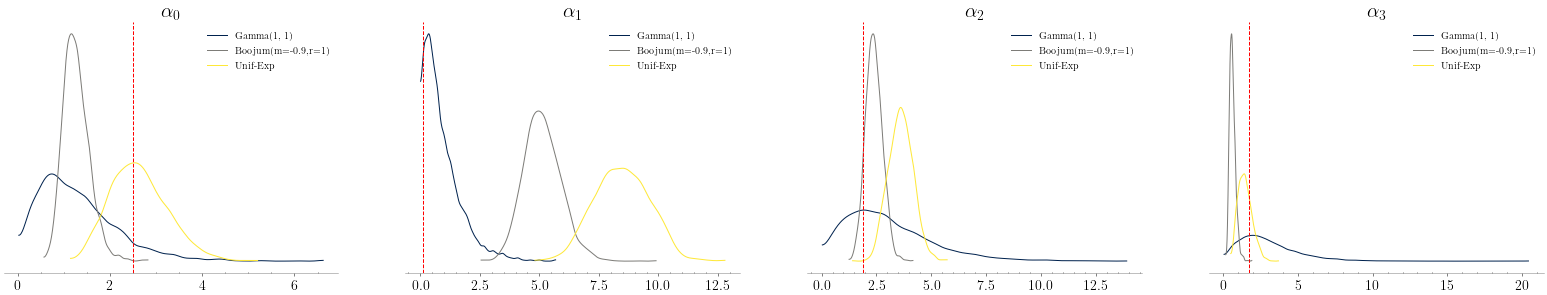

In [296]:
colors = matplotlib.cm.get_cmap('cividis', 3)
ax = az.plot_posterior(model_fit1, var_names=['alpha'], hdi_prob='hide', point_estimate=None, color=colors(0), label='Gamma(1, 1)')
az.plot_posterior(model_fit2, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color=colors(1), label='Boojum(m=-0.9,r=1)')
az.plot_posterior(model_fit3, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color=colors(2), label='Unif-Exp')

for i in range(4):
    ax[i].set_title(r'$\alpha_{}$'.format(i), fontsize=20)
    ax[i].axvline(true_alpha[i], color='red', linestyle='--')

plt.show()

In [47]:
data['prior_alpha'] = 1
model_fit1 = model3.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


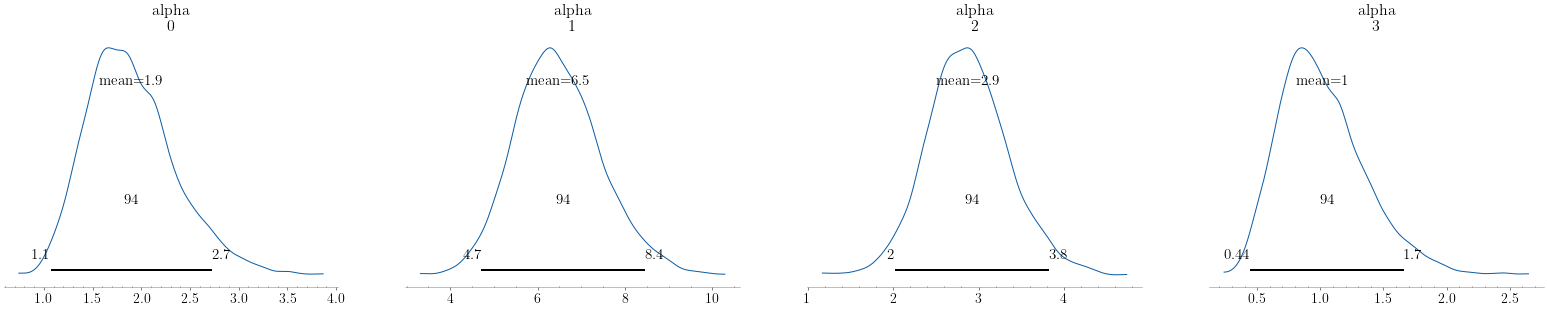

In [50]:
az.plot_posterior(model_fit1, var_names=['alpha'])
plt.show()

## Gain of increasing the dataset size

Here we vary the value of $n$ and see the posterior shape.

In [38]:
true_alpha = np.array([2,7,3,1])
n_values = [10, 50, 100, 500, 1000]
alpha_samples = np.zeros((len(n_values),4000,4))
data['prior_alpha'] = 1

for i, n in tqdm.tqdm(enumerate(n_values)):
    data['n'] = n
    data['xy'] = generate_data(true_alpha, n, seed=920392)
    model_fit = model2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    alpha_samples[i,:,:] = model_fit.stan_variable('alpha')

5it [00:41,  8.20s/it]


## Simulated-based calibration

https://arxiv.org/pdf/1804.06788.pdf

https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html

Consider the prior $\alpha \sim \operatorname{Gamma}(a=1, b=1)$

In [42]:
a, b = 1, 1

# Gamma hyperparameters
a = a*np.ones(4)
b = b*np.ones(4)

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

n = 50

data = {'n': n, 'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c}

R = 10

Let's see the distribution of $\rho = \#\{\alpha_1 < \hat{\alpha}_1\}$.

In [ ]:
rho_values = []
rng = np.random.RandomState(831290)
for i in tqdm.tqdm(range(200)):
    true_alpha = rng.gamma(shape=a, scale=1/b, size=4)
    seed=rng.randint(100000)
    XY = generate_data(true_alpha, n, seed=seed)
    # Sometimes, numpy sampler is not good when alpha is small.
    XY[XY>=1] = 1 - 1e-10
    XY[XY<=0] = 1e-10
    data['xy'] = XY
    model_fit = model3.sample(data=data, iter_warmup=1000, iter_sampling=1000, chains=1, adapt_delta=0.9,
                              show_progress=False, show_console=False)
    alpha1 = np.random.choice(model_fit.stan_variables()['alpha'][:,0], size=R, replace=False)
    rho = np.sum(alpha1 > true_alpha[0])
    rho_values.append({'rho': rho, 
                       'diagnose': model_fit.diagnose(),
                       'true_alpha': true_alpha, 
                       'seed': seed,
                       'XY': XY})

## Dealing with bad situations

In [277]:
true_alpha = np.array([2.5, 0.01, 1.9, 1.8])#rho_values[0]['true_alpha']
seed=3782910#rho_values[0]['seed']
XY = generate_data(true_alpha, n=50, seed=seed)
# Sometimes, numpy sampler is not good when alpha is small.
XY[XY>=1] = 1 - 1e-10
XY[XY<=0] = 1e-10
data['xy'] = XY
data['n'] = 50
model_fit = model5.sample(data=data, iter_warmup=1000, iter_sampling=1000, chains=4, adapt_delta=0.9,
                          max_treedepth=12,
                          show_progress=True, show_console=False)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [278]:
inf_data = az.convert_to_inference_data(model_fit)

In [279]:
print(model_fit.diagnose())

Processing csv files: /tmp/tmppinj2b1w/bivariate-beta-model-v5-20220715020803_1.csv, /tmp/tmppinj2b1w/bivariate-beta-model-v5-20220715020803_2.csv, /tmp/tmppinj2b1w/bivariate-beta-model-v5-20220715020803_3.csv, /tmp/tmppinj2b1w/bivariate-beta-model-v5-20220715020803_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
696 of 4000 (17.40%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.24, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

Split R-hat values satisfactory all paramet

In [280]:
model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-110.00,1.30000,14.000,-130.00,-110.00,-84.00,130.0,41.0,1.0
alpha[1],1.80,0.00820,0.280,1.40,1.80,2.30,1179.0,365.0,1.0
alpha[2],0.21,0.00720,0.085,0.11,0.19,0.38,142.0,44.0,1.0
alpha[3],1.90,0.00900,0.290,1.50,1.90,2.40,1008.0,312.0,1.0
alpha[4],1.50,0.00760,0.240,1.10,1.50,1.90,972.0,301.0,1.0
...,...,...,...,...,...,...,...,...,...
z2[46],0.97,0.00120,0.048,0.86,0.99,1.00,1735.0,537.0,1.0
z2[47],0.94,0.00270,0.092,0.72,0.99,1.00,1126.0,348.0,1.0
z2[48],0.98,0.00063,0.029,0.91,1.00,1.00,2187.0,677.0,1.0


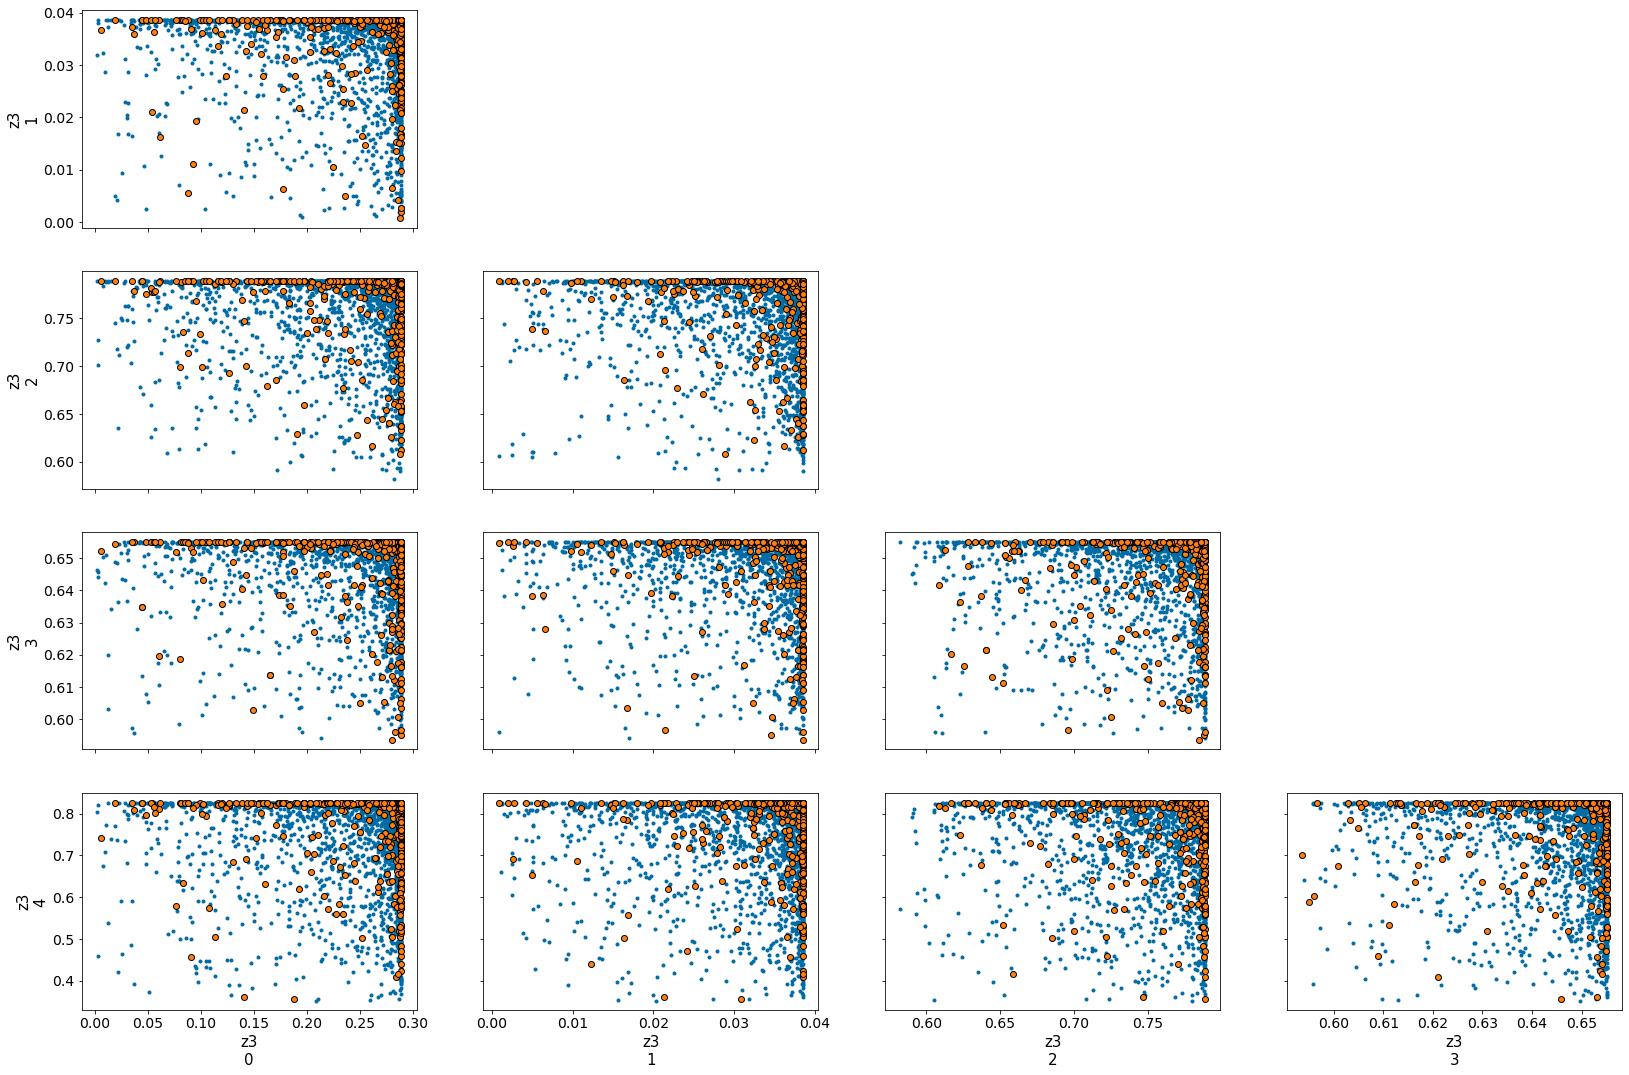

In [281]:
az.plot_pair(inf_data, var_names=('z3'), coords={'z3_dim_0': [0,1,2,3,4]}, divergences=True)
plt.show()

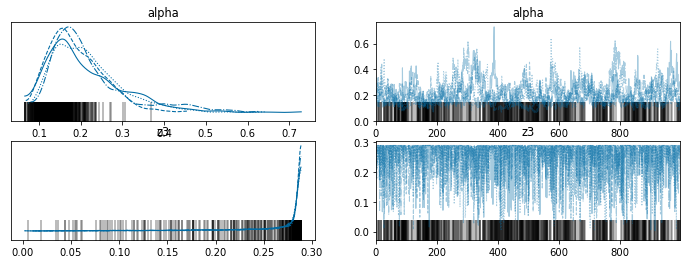

In [286]:
az.plot_trace(inf_data, var_names=('alpha', 'z3'), coords={'z3_dim_0':[0], 'alpha_dim_0':[1]})
plt.show()

## Testing

In [30]:
true_alpha = np.array([2.5, 0.1, 1.9, 1.8])
n = 1

rng = np.random.default_rng(seed=903321)
U1 = rng.beta(true_alpha[0], true_alpha[1], size=n)
U2 = rng.beta(true_alpha[2], true_alpha[3], size=n)

data = {'x': U1+U2, 'n': n}
data.update(dict(zip('abcd', true_alpha)))

fit = simple_model.sample(data=data, seed=1000, adapt_delta=0.8, iter_sampling=100000, iter_warmup=90000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [31]:
draws = fit.draws_pd()

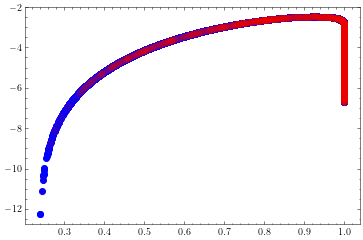

In [32]:
plt.scatter(draws[draws['divergent__'] == 0]['u[1]'], 
            draws[draws['divergent__'] == 0]['lp__'], 
            color='blue')
plt.scatter(draws[draws['divergent__'] == 1]['u[1]'],
            draws[draws['divergent__'] == 1]['lp__'], 
            color='red', alpha=0.05)

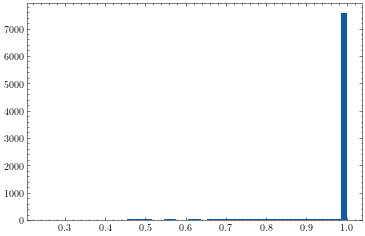

In [33]:
plt.hist(draws[draws['divergent__'] == 1]['u[1]'], bins=50)
plt.show()

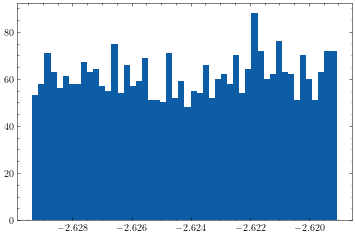

In [41]:
plt.hist(draws[(draws['u[1]'] > 0.99)&(draws['u[1]'] < 0.991)]['lp__'], bins=50)
plt.show()

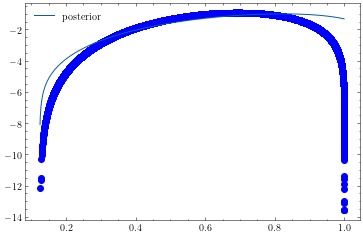

In [29]:
t = np.linspace(U1+U2-1,1,1000,endpoint=False)
plt.plot(t, stats.beta(true_alpha[0], true_alpha[1]).logpdf(t) + \
            stats.beta(true_alpha[2], true_alpha[3]).logpdf(U1+U2-t) - 1.8,
         label='posterior')
plt.scatter(draws[draws['divergent__'] == 0]['u[1]'], 
            draws[draws['divergent__'] == 0]['lp__'], 
            color='blue')
plt.scatter(draws[draws['divergent__'] == 1]['u[1]'],
            draws[draws['divergent__'] == 1]['lp__'], 
            color='red')
plt.legend()
plt.show()

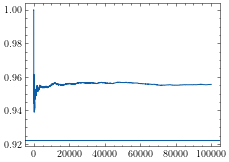

In [299]:
plt.plot(np.cumsum(fit.draws()[:,1,-1])/np.linspace(1, 100000,100000))
plt.axhline(U1)
plt.show()

In [300]:
fit.draws()[:,:,-1].mean()

0.9557283527749998

## Analyzing the estimation

In [ ]:
def estimating_error(true_alpha, n, monte_carlo_simulation):
    
    U = np.random.dirichlet(true_alpha, size=(n, monte_carlo_simulation))
    X = U[:,:,0] + U[:,:,1]
    Y = U[:,:,0] + U[:,:,2]
    
    # Gamma hyperparameters
    a = 2*np.array([1,1,1,1])
    b = 0.1*np.array([1,1,1,1])

    # bojum prior
    m = -0.9
    r = b

    # uniform-exponential prior
    p = 0.5*np.ones(4)
    lambd = np.ones(4)
    c = 100*np.ones(4)

    data = {'n': n,
            'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
            'tolerance': 1e-8}
    
    mse = np.zeros(4)
    bias = np.zeros(4)
    coverage = np.zeros(4)
    mape = np.zeros(4)

    for i in tqdm.tqdm(range(monte_carlo_simulation)):
        XY = np.column_stack([X[:,i],Y[:,i]])
        data['xy'] = XY
        model_fit_v2 = model_v2.sample(data=data, chains=4, iter_warmup=1500, iter_sampling=1000, 
                                       show_progress=False, show_console=False)
        df = model_fit_v2.summary(percentiles=(2.5, 97.5))

        alpha_hat = df.iloc[1:5].Mean.values
        lb = df.iloc[1:5]['2.5%'].values
        ub = df.iloc[1:5]['97.5%'].values

        bias_new = alpha_hat - true_alpha
        mse_new = bias_new * bias_new
        mape_new = abs(bias_new)/true_alpha
        coverage_new = (lb < true_alpha)*(ub > true_alpha)

        bias = (bias * i + bias_new)/(i+1)
        mse = (mse * i + mse_new)/(i+1)
        mape = (mape * i + mape_new)/(i+1)
        coverage = (coverage * i + coverage_new)/(i+1)
    
    return bias, mse, mape, coverage

In [ ]:
n = 50
monte_carlo_simulation = 1000

true_alpha = np.array([1,1,1,1])
bias1, mse1, mape1, coverage1 = estimating_error(true_alpha, n, monte_carlo_simulation)

In [ ]:
true_alpha = np.array([2,7,3,1])
bias2, mse2, mape2, coverage2 = estimating_error(true_alpha, n, monte_carlo_simulation)

In [ ]:
true_alpha = np.array([0.7, 0.9, 2.0, 1.5])
bias3, mse3, mape3, coverage3 = estimating_error(true_alpha, n, monte_carlo_simulation)

In [ ]:
bias1, mse1, mape1, coverage1

In [64]:
n = 50
monte_carlo_simulation = 100
true_alpha = np.array([2,7,3,1])

U = np.random.dirichlet(true_alpha, size=(n, monte_carlo_simulation))
X = U[:,:,0] + U[:,:,1]
Y = U[:,:,0] + U[:,:,2]

# Gamma hyperparameters
a = 1*np.array([1,1,1,1])
b = 1*np.array([1,1,1,1])

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.9*np.ones(4)
lambd = np.ones(4)
c = 50*np.ones(4)

data = {'n': n,
        'prior_alpha': 4, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

mse = np.zeros(4)
bias = np.zeros(4)
coverage = np.zeros(4)
mape = np.zeros(4)

for i in tqdm.tqdm(range(monte_carlo_simulation)):
    XY = np.column_stack([X[:,i],Y[:,i]])
    data['xy'] = XY
    model_fit = model_v3.sample(data=data, chains=4, iter_warmup=1000, iter_sampling=1000, 
                                   show_progress=False, show_console=False, adapt_delta=0.95)
    df = model_fit.summary(percentiles=(2.5, 50, 97.5))

    #alpha_hat = df.iloc[1:5].Mean.values
    alpha_hat = df.iloc[1:5]['50%'].values
    lb = df.iloc[1:5]['2.5%'].values
    ub = df.iloc[1:5]['97.5%'].values

    bias_new = alpha_hat - true_alpha
    mse_new = bias_new * bias_new
    mape_new = abs(bias_new)/true_alpha
    coverage_new = (lb < true_alpha)*(ub > true_alpha)

    bias = (bias * i + bias_new)/(i+1)
    mse = (mse * i + mse_new)/(i+1)
    mape = (mape * i + mape_new)/(i+1)
    coverage = (coverage * i + coverage_new)/(i+1)

  0%|                                                   | 0/100 [00:00<?, ?it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  1%|▍                                          | 1/100 [00:02<04:01,  2.44s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  2%|▊                                          | 2/100 [00:04<03:51,  2.36s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  3%|█▎                                         | 3/100 [00:06<03:43,  2.31s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  4%|█▋                                         | 4/100 [00:09<03:55,  2.46s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  5%|

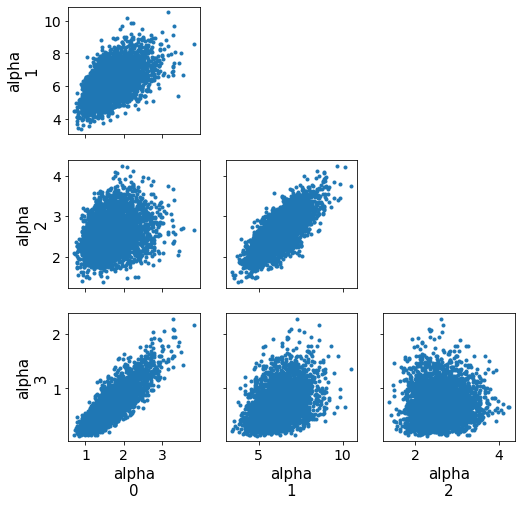

In [65]:
fig, ax = plt.subplots(3,3, figsize=(8,8))
az.plot_pair(model_fit, var_names=('alpha'), ax=ax)
plt.show()

In [66]:
bias, mse, mape, coverage

(array([-0.279 , -1.122 , -0.428 , -0.1309]),
 array([0.1775  , 1.7204  , 0.3228  , 0.093975]),
 array([0.1735    , 0.16457143, 0.15933333, 0.2469    ]),
 array([0.88, 0.77, 0.77, 0.9 ]))

## ABC Algorithm

We first define the models: gamma and bivariate beta

In [223]:
from abcpy.probabilisticmodels import ProbabilisticModel, Continuous, InputConnector
from abcpy.statistics import Identity, LinearTransformation
from abcpy.distances import Euclidean, Distance
from abcpy.perturbationkernel import DefaultKernel
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import SMCABC, PMCABC

In [46]:
class Gamma(ProbabilisticModel, Continuous):
    
    def __init__(self, parameters, name='Gamma'):
        # We expect input of type parameters = [alpha, beta]
        if not isinstance(parameters, list):
            raise TypeError('Input of Gamma model is of type list')
        if len(parameters) != 2:
            raise RuntimeError('Input list must be of length 2, containing [alpha, beta].')

        input_connector = InputConnector.from_list(parameters)
        super().__init__(input_connector, name)
        
    def _check_input(self, input_values):
        # Check whether input has correct type or format
        if len(input_values) != 2:
            raise ValueError('Number of parameters of Gamma model must be 2.')

        # Check whether input is from correct domain
        alpha = input_values[0]
        beta = input_values[1]
        if alpha <= 0 or beta <= 0:
            return False

        return True
    
    def forward_simulate(self, input_values, k, rng=np.random.RandomState()):
        # Extract the input parameters
        alpha = input_values[0]
        beta = input_values[1]

        # Do the actual forward simulation
        vector_of_k_samples = rng.gamma(shape=alpha, scale=1/beta, size=k)

        # Format the output to obey API
        result = [np.array([x]) for x in vector_of_k_samples]
        return result
    
    def _check_output(self, values):
        if values <= 0:
            return False
        return True
    
    def get_output_dimension(self):
        return 1

    def pdf(self, input_values, x):
        alpha = input_values[0]
        beta = input_values[1]
        pdf = stats.gamma(a=alpha, scale=1/beta).pdf(x)
        return pdf
    
class BivariateBeta(ProbabilisticModel, Continuous):
    
    def __init__(self, parameters, name='BivariateBeta'):
        # We expect input of type parameters = [alpha1, ..., alpha4]
        if not isinstance(parameters, list):
            raise TypeError('Input of BIvariate Beta model is of type list')
        if len(parameters) != 4:
            raise RuntimeError('Input list must be of length 1, containing [alpha].')
        input_connector = InputConnector.from_list(parameters)
        
        super().__init__(input_connector, name)
        
    def _check_input(self, input_values):
        # Check whether input has correct type or format
        if len(input_values) != 4:
            raise ValueError('Number of parameters of Bivariate Beta model must be 4.')

        # Check whether input is from correct domain
        alpha = np.array(input_values)
        if sum(alpha < 0) != 0:
            return False

        return True
    
    def forward_simulate(self, input_values, k, rng=np.random.RandomState()):
        # Extract the input parameters
        alpha = input_values

        # Do the actual forward simulation
        U = rng.dirichlet(alpha, size=k)
        vector_of_k_samples = np.column_stack([U[:,0]+U[:,1], U[:,0]+U[:,2]])

        # Format the output to obey API
        result = [vector_of_k_samples[i,:] for i in range(k)]
        return result
    
    def _check_output(self, values):
        if sum(values < 0) + sum(values > 1) > 0:
            return False
        return True
    
    def get_output_dimension(self):
        return 2

    def pdf(self, input_values, x):
        alpha = input_values
        distribution = bb_class(alpha)
        return distribution.pdf(x[0], x[1])
    
class Absolute_sufficient_statistics(Distance):

    def __init__(self, statistics_calc):
        super().__init__(statistics_calc)
        self.s1_mean = None

    def distance(self, d1, d2):
        s1, s2 = self._calculate_summary_stat(d1, d2)
        if self.s1_mean is None:
            self.s1_mean = s1.mean(axis=0)
        return np.sum(abs(self.s1_mean - s2.mean(axis=0)))
    
    def dist_max(self):
        return 5

We can now work with these models

In [101]:
# Defining priors
alpha1 = Gamma([[2], [.1]], name='alpha1')
alpha2 = Gamma([[2], [.1]], name='alpha2')
alpha3 = Gamma([[2], [.1]], name='alpha3')
alpha4 = Gamma([[2], [.1]], name='alpha4')

# Defining the model
xy = BivariateBeta([alpha1, alpha2, alpha3, alpha4], name='xy')

# Defining Statistics
statistics_calculator = Identity(degree=2, cross=True)

# Defining Distance
distance_calculator = Euclidean(statistics_calculator)

# Defining Kernel
kernel = DefaultKernel([alpha1, alpha2, alpha3, alpha4])

# Defining Backend: the dummy backend does not parallelize the code!
backend = Backend()

# Defining sampling scheme
sampler = PMCABC([xy], [distance_calculator], backend, kernel, seed=1)

Now we can work with the sampler. First, generate some data.

In [102]:
U = np.random.dirichlet([1,1,1,1], size=50)
X = U[:,0]+U[:,1]
Y = U[:,0]+U[:,2]
XY = list(np.column_stack([X,Y]))

In [104]:
par = journal.get_parameters()
# post analysis
print(journal.posterior_mean())

{'alpha1': 20.60332059558052, 'alpha2': 21.980951628204792, 'alpha3': 18.247054482087105, 'alpha4': 18.355770830519784}


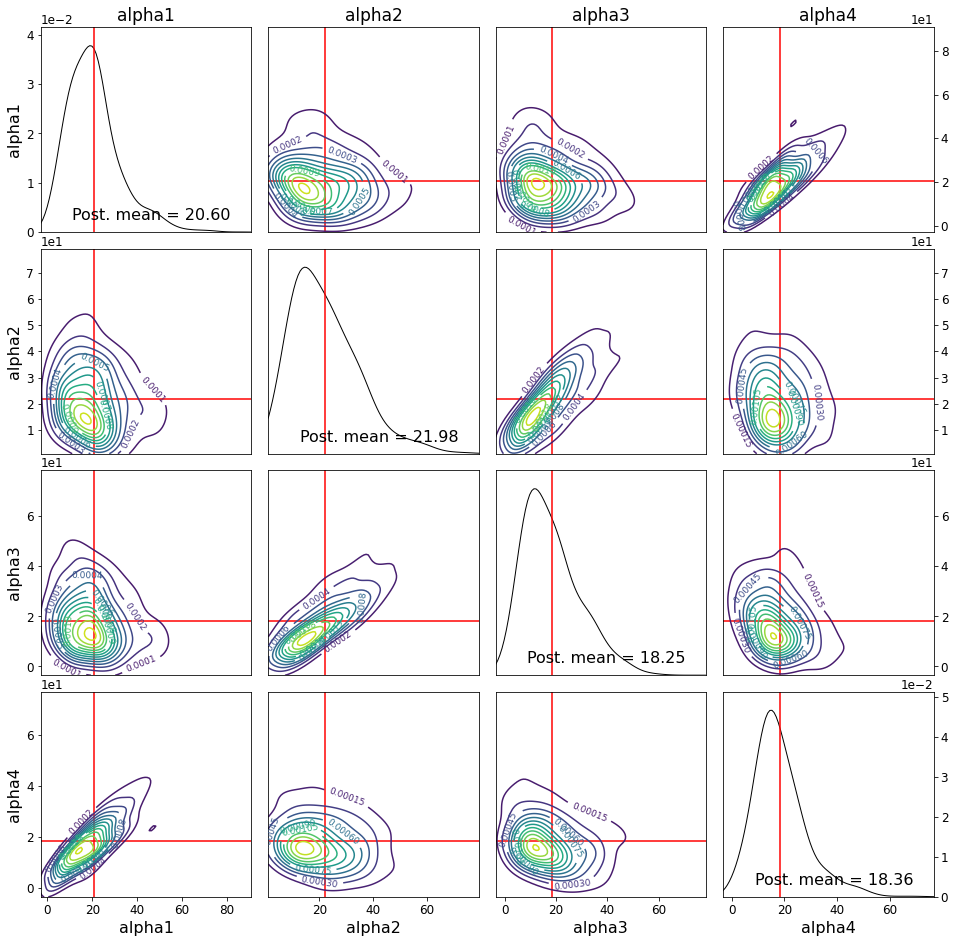

In [105]:
journal.plot_posterior_distr()
plt.show()

In [98]:
U = np.random.dirichlet(list(journal.posterior_mean().values()), size=50)
X = U[:,0]+U[:,1]
Y = U[:,0]+U[:,2]
XY2 = list(np.column_stack([X,Y]))

In [92]:
statistics_calculator.statistics(XY).mean(axis=0)

array([0.5234177 , 0.46710019, 0.33206864, 0.264394  , 0.2579746 ])

In [99]:
statistics_calculator.statistics(XY2).mean(axis=0)

array([0.54357259, 0.47938602, 0.29828656, 0.23389661, 0.26130551])